In [1]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from glob import glob
from skimage import io
import numpy as np
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import (separate_stains, combine_stains,
                            hdx_from_rgb, rgb_from_hdx,rgb2hed, hed2rgb)
import tensorflow as tf
from tensorflow import keras
import os
import time


# Funciones

In [2]:
#Leer el conjunto de imagenes
def LeerImagenes(imagenes):
    imgs=[]
    for x in range(0,len(imagenes)):
        imgs.append(io.imread(imagenes[x]))
    MImagenes=np.array(imgs)
    
    return MImagenes

In [3]:
#Crea matriz con las etiquetas de las imagenes
def CalculoEtiquetas(imagenes):
    Etiquetas=[]
    for x in range(0,len(imagenes)):
        Clasificacion =imagenes[x].split('-') 
        for i in range(0,len(Clasificacion)) :
            Valores=(Clasificacion[2])
            Numero=Valores.split('_')
        Etiquetas.append(int(Numero[1]))
        #Etiquetas=np.array(etiquetas)
    return Etiquetas

In [4]:
#Aplico filtro al conjunto de imagenes ingresados cono paramentro
def AplicarFiltro(MImagenes):
    imgs_con_filtro=[]
    for x in range(0,len(MImagenes)):
        ihc_hdx = rgb2hed(MImagenes[x])
        null = np.zeros_like(ihc_hdx[:, :, 0])
        ihc_h = hed2rgb(np.stack((ihc_hdx[:, :, 0], null, null), axis=-1))
        ihc_d = hed2rgb(np.stack((null, ihc_hdx[:, :, 1], null), axis=-1))
        ihc_x = hed2rgb(np.stack((null, null, ihc_hdx[:, :, 2]), axis=-1))

        h = rescale_intensity(ihc_hdx[:, :, 0], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 0], 99)))
        d = rescale_intensity(ihc_hdx[:, :, 2], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 2], 99)))
    
        zdh = np.dstack((null, d, h))
        imgs_con_filtro.append(zdh)
    Imagenes_con_fitro=np.array(imgs_con_filtro)
    return Imagenes_con_fitro

In [5]:
#Obtiene el canal DAB de las imagenes representativas ingresadas
def ImagenDAB(MImagenes):
    imgs_DAB=[]
    for x in range(0,len(MImagenes)):
        ihc_hdx = rgb2hed(MImagenes[x])
        null = np.zeros_like(ihc_hdx[:, :, 0])
        #Seleccionó solo el canal DAB
        ihc_x = hed2rgb(np.stack((null, null, ihc_hdx[:, :, 2]), axis=-1)) 
        #Guardo solo el canal DAB 
        imgs_DAB.append(ihc_x)
    Imagenes_DAB=np.array(imgs_DAB)
    return Imagenes_DAB

In [6]:
#Obtiene los valores promedios de cada clase y los valores min y max de estos, segun las imagenes representativas ingresadas

def CalculoPromedios(Imagenes_DAB,Etiquetas):
    Prom0=[]
    Prom1=[]
    Prom2=[]
    Prom3=[]
    Prom_imgs=[]
    for x in range(0,len(Imagenes_DAB)):
        Promedio=np.mean(Imagenes_DAB[x])
        Prom_imgs.append(Promedio)
    for x in range(0,len(Etiquetas)):
        if Etiquetas[x]==0:
            Prom0.append(Prom_imgs[x])
        elif Etiquetas[x]==1:
            Prom1.append(Prom_imgs[x])
        elif Etiquetas[x]==2:
            Prom2.append(Prom_imgs[x])
        elif Etiquetas[x]==3:   
            Prom3.append(Prom_imgs[x])
        else:
            print("Error en la etiqueta") 
    Min0=min(Prom0)        
    Max0=max(Prom0)
    Min1=min(Prom1)
    Max1=max(Prom1)
    Min2=min(Prom2)
    Max2=max(Prom2)
    Min3=min(Prom3)
    Max3=max(Prom3)
    return Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3

In [7]:
#Filtra, quitando las imagenes que no cumplan con los valores asignados para su clase, retornando el conjunto de imagenes que 
#cumplen con los requisitos

def SemiFiltro(Imagenes,Etiquetas,Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3):
    Imgs=[]
    etqs=[]
    Imgs_DAB=ImagenDAB(Imagenes)
            
    for x in range(0,len(Imagenes)):
        Promedio=np.mean(Imgs_DAB[x])
        if Etiquetas[x]==0:
            if Promedio>=Min0 and Promedio<=Max0:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        elif Etiquetas[x]==1:
            if Promedio>=Min1 and Promedio<=Max1:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        elif Etiquetas[x]==2:
            if Promedio>=Min2 and Promedio<=Max2:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        elif Etiquetas[x]==3:   
            if Promedio>=Min3 and Promedio<=Max3:
                Imgs.append(Imagenes[x])
                etqs.append(Etiquetas[x])
        else:
            print("Error en la etiqueta")
    Imagenes=np.array(Imgs)
    Etqs=np.array(etqs)
    return Imagenes,Etqs    

# PREPROCESAMIENTO

In [8]:
# Constantes
data_source = "../data(1000)/"
models_dir = '../saved_models/'
train_imgs = glob(f"{data_source}training/*.png")
test_imgs = glob(f"{data_source}test/*.png")
I_representativas=glob(f"{data_source}Imagenes_representativas/*.png")

In [9]:
#leer imagenes
Imagenes_rep=LeerImagenes(I_representativas)
Etiquetas_rep=CalculoEtiquetas(I_representativas)
X_train=LeerImagenes(train_imgs)
y_train=CalculoEtiquetas(train_imgs)
X_test=LeerImagenes(test_imgs)
y_test=CalculoEtiquetas(test_imgs)

In [10]:
ImagenesDAB=ImagenDAB(Imagenes_rep)
Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3=CalculoPromedios(ImagenesDAB,Etiquetas_rep)
Train_X_final,Train_Y_final=SemiFiltro(X_train,y_train,Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3)
Test_X_final,Test_Y_final=SemiFiltro(X_test,y_test,Min0,Max0,Min1,Max1,Min2,Max2,Min3,Max3) 

In [11]:
print(len(Test_X_final))
print(len(Train_X_final))

265
1143


In [12]:
n_classes = 4
Y_train = np_utils.to_categorical(Train_Y_final, n_classes)
Y_test = np_utils.to_categorical(Test_Y_final, n_classes)

# Creación de CNN

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(300,300,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 384)       8

In [14]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [15]:
#model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.optimizers.SGD(lr=0.001))

In [16]:
model.fit(Train_X_final, Y_train, epochs=50,validation_data=(Test_X_final, Y_test),validation_freq = 1,callbacks = [tensorboard_cb])

Epoch 1/50
 1/36 [..............................] - ETA: 0s - loss: 4.9516 - accuracy: 0.1562WARNING:tensorflow:From C:\Users\camii\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
36/36 [==============================] - 62s 2s/step - loss: 1.8909 - accuracy: 0.4882 - val_loss: 15.2267 - val_accuracy: 0.2981
Epoch 2/50
36/36 [==============================] - 61s 2s/step - loss: 1.0900 - accuracy: 0.6833 - val_loss: 7.8062 - val_accuracy: 0.2981
Epoch 3/50
36/36 [==============================] - 61s 2s/step - loss: 0.9631 - accuracy: 0.7113 - val_loss: 4.7015 - val_accuracy: 0.2906
Epoch 4/50
36/36 [==============================] - 61s 2s/step - loss: 0.7287 - accuracy: 0.7673 - val_loss: 2.3783 - val_accuracy: 0.2453
Epoch 5/50
36/36 [==============================] - 61s 2s/step - loss: 0.7

In [17]:
X_pred=model.predict(Test_X_final)

In [21]:
cnf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_test.argmax(axis=1))
print(cnf_matrix)

[[ 0 65  0  0]
 [ 0 53  6  0]
 [ 0 19 43  0]
 [ 0  0  0 79]]


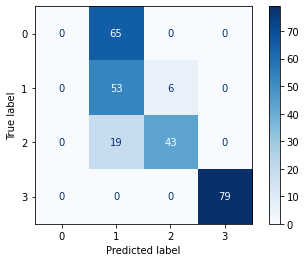

In [22]:
disp = plot_confusion_matrix(classifier, X_pred, Y_test.argmax(axis=1),
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [23]:
print(cnf_matrix.sum(axis=0))
print(np.diag(cnf_matrix) )
print(cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) )

[  0 137  49  79]
[ 0 53 43 79]
[ 0 84  6  0]


In [24]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

C:\Users\camii\AppData\Local\Temp/ipykernel_14012/1338496663.py:14: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
C:\Users\camii\AppData\Local\Temp/ipykernel_14012/1338496663.py:22: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


In [25]:
# Print the precision and recall, among other metrics
print(classification_report(Test_Y_final, predicted_labels, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        65
           1      0.387     0.898     0.541        59
           2      0.878     0.694     0.775        62
           3      1.000     1.000     1.000        79

    accuracy                          0.660       265
   macro avg      0.566     0.648     0.579       265
weighted avg      0.590     0.660     0.600       265



C:\Users\camii\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camii\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camii\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
